In [3]:
import numpy as np

In [4]:
class MLP:
    """
    MLP class
    Initialize a model
    Handles training and testing of the model
    """
    def __init__(self, inputSize, hiddenLayerSize, outputSize):
        """
        Inputs:
            inputSize: size of input
            hiddenLayerSize: a list containing the number of units per hidden layer
            outputSize: size of output
        """
        self.__inputSize = inputSize
        self.__hiddenLayerSize = hiddenLayerSize
        self.__outputSize = outputSize
        self.__layers = [inputSize] + hiddenLayerSize + [outputSize]
        
        self.__weights = [] # the weight matrix
        # initializing weights
        for i in range(len(self.__layers) - 1):
            # connection between previous layer's neurons to next layer's neurons
            # Dense
            # normal distribution, mean 0, std 0.01
            self.__weights.append(np.random.normal(0, 0.01, (self.__layers[i+1], self.__layers[i])))
            
        self.__biases = []
        for i in range(1, len(self.__layers)):
            # biases per activation unit
            # just using 0s as initial bias
            self.__biases.append(np.zeros((self.__layers[i], 1)))
            
        self.__dweights = []
        for i in range(len(self.__layers) - 1):
            # partial derivatives of the loss function with respect to the weights
            self.__dweights.append(np.zeros((self.__layers[i+1], self.__layers[i])))
            
        self.__dbiases = []
        for i in range(1, len(self.__layers)):
            # partial derivatives of the loss function with respect to the biases
            self.__dbiases.append(np.zeros((self.__layers[i], 1)))
            
        self.__activations = []
        for i in range(len(self.__layers)):
            # cache of different actions per propagation
            self.__activations.append(np.zeros((self.__layers[i], 1)))
            
        self.__activationInputs = []
        for i in range(len(self.__layers)):
            # cache for the z_i/inputs to the activation layer
            self.__activationInputs.append(np.zeros((self.__layers[i], 1)))

In [8]:
model=MLP(2, [3], 1)
print(model.__dict__)

{'_MLP__inputSize': 2, '_MLP__hiddenLayerSize': [3], '_MLP__outputSize': 1, '_MLP__layers': [2, 3, 1], '_MLP__weights': [array([[-0.0190064 , -0.02923617],
       [-0.01613302,  0.00798908],
       [-0.02203662, -0.00628966]]), array([[ 0.01372489,  0.00868267, -0.00311195]])], '_MLP__biases': [array([[0.],
       [0.],
       [0.]]), array([[0.]])], '_MLP__dweights': [array([[0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0., 0.]])], '_MLP__dbiases': [array([[0.],
       [0.],
       [0.]]), array([[0.]])], '_MLP__activations': [array([[0.],
       [0.]]), array([[0.],
       [0.],
       [0.]]), array([[0.]])], '_MLP__activationInputs': [array([[0.],
       [0.]]), array([[0.],
       [0.],
       [0.]]), array([[0.]])]}


In [10]:
def gaussian(x, mu=0, sigma=1):
    """
    Computes the Gaussian function for the input x.
    
    Parameters:
    x : array-like
        The input values.
    mu : float
        The mean (center) of the Gaussian distribution.
    sigma : float
        The standard deviation (spread) of the Gaussian distribution.
        
    Returns:
    Gaussian value evaluated at x.
    """
    # Compute the Gaussian function
    gauss = (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-((x - mu)**2) / (2 * sigma**2))
    
    # Clip the output to avoid numerical issues (e.g., very small values near 0)
    gauss = np.clip(gauss, 1e-10, None)  # Clip the minimum value to avoid underflow
    
    return gauss
   
def derivative_gaussian(x, mu=0, sigma=1):
    """
    Computes the derivative of the Gaussian function for the input x.
    
    Parameters:
    x : array-like
        The input values.
    mu : float
        The mean (center) of the Gaussian distribution.
    sigma : float
        The standard deviation (spread) of the Gaussian distribution.
        
    Returns:
    Derivative of the Gaussian value evaluated at x.
    """
    gauss_val = gaussian(x, mu, sigma)
    derivative = -((x - mu) / sigma**2) * gauss_val
    return derivative

def identity(x):
    return x

def derivative_identity(x):
    return np.ones_like(x)

def int_to_onehot(y, num_classes):
    onehot = np.zeros((len(y), num_classes))
    onehot[np.arange(len(y)), y] = 1
    return onehot

class InitializeModel:
    def __init__(self, random_seed=123):
        print("Model initialization")
        self.random_seed = random_seed
        self.rng = np.random.RandomState(random_seed)

class GaussianMLP(InitializeModel):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__(random_seed)

        self.num_classes = num_classes

        # Initialize weights
        self.weights1 = self.rng.normal(0, 0.01, (num_hidden1, num_features))
        self.weights2 = self.rng.normal(0, 0.01, (num_hidden2, num_hidden1))
        self.weights3 = self.rng.normal(0, 0.01, (num_classes, num_hidden2))

        # Store metrics for book keeping
        self.metrics = dict()

        print("Model initialized")
        print("First hidden layer weights: ", self.weights1)
        print("Second hidden layer weights: ", self.weights2)
        print("Output layer weights: ", self.weights3)

    def set_weights(self, weights1, weights2, weights3):
        self.weights1 = weights1
        self.weights2 = weights2
        self.weights3 = weights3

    def forward(self, x):
        self.z1 = np.dot(self.weights1, x)
        self.a1 = gaussian(self.z1)
        self.z2 = np.dot(self.weights2, self.a1)
        self.a2 = gaussian(self.z2)
        self.z3 = np.dot(self.weights3, self.a2)
        self.a3 = identity(self.z3)
        return self.a3

    def backward(self, x, y, learning_rate=0.01):
        # Forward pass
        output = self.forward(x)

        # Compute the error
        error = output - y

        # Backward pass
        d_z3 = error * derivative_identity(self.z3)
        d_weights3 = np.dot(d_z3, self.a2.T)

        d_a2 = np.dot(self.weights3.T, d_z3)
        d_z2 = d_a2 * derivative_gaussian(self.z2)
        d_weights2 = np.dot(d_z2, self.a1.T)

        d_a1 = np.dot(self.weights2.T, d_z2)
        d_z1 = d_a1 * derivative_gaussian(self.z1)
        d_weights1 = np.dot(d_z1, x.T)

        # Update weights
        self.weights1 -= learning_rate * d_weights1
        self.weights2 -= learning_rate * d_weights2
        self.weights3 -= learning_rate * d_weights3

In [12]:
model=GaussianMLP(2, 2, 2, 1)
model

Model initialization
Model initialized
First hidden layer weights:  [[-0.01085631  0.00997345]
 [ 0.00282978 -0.01506295]]
Second hidden layer weights:  [[-0.005786    0.01651437]
 [-0.02426679 -0.00428913]]
Output layer weights:  [[ 0.01265936 -0.0086674 ]]


In [30]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Function to plot activations given weights and biases
def plot_activations(weights1, weights2, weights3, bias1, bias2, bias3):
    # Generate a uniform 2D distribution of input points
    x1 = np.linspace(-1, 1, 100)
    x2 = np.linspace(-1, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    inputs = np.vstack([X1.ravel(), X2.ravel()])

    # Compute the activations for each layer
    z1 = np.dot(weights1, inputs) + bias1[:, None]
    a1 = gaussian(z1)

    z2 = np.dot(weights2, a1) + bias2[:, None]
    a2 = gaussian(z2)

    z3 = np.dot(weights3, a2) + bias3[:, None]
    a3 = identity(z3)

    # Reshape the activations for plotting
    a1_reshaped = a1.reshape(2, 100, 100)
    a2_reshaped = a2.reshape(2, 100, 100)
    a3_reshaped = a3.reshape(1, 100, 100)

    # Plot the activations
    fig = plt.figure(figsize=(18, 12))

    # Hidden layer 1, unit 1
    ax = fig.add_subplot(231, projection='3d')
    ax.plot_surface(X1, X2, a1_reshaped[0], cmap='viridis')
    ax.set_title('Hidden Layer 1, Unit 1')

    # Hidden layer 1, unit 2
    ax = fig.add_subplot(232, projection='3d')
    ax.plot_surface(X1, X2, a1_reshaped[1], cmap='viridis')
    ax.set_title('Hidden Layer 1, Unit 2')

    # Hidden layer 2, unit 1
    ax = fig.add_subplot(233, projection='3d')
    ax.plot_surface(X1, X2, a2_reshaped[0], cmap='viridis')
    ax.set_title('Hidden Layer 2, Unit 1')

    # Hidden layer 2, unit 2
    ax = fig.add_subplot(234, projection='3d')
    ax.plot_surface(X1, X2, a2_reshaped[1], cmap='viridis')
    ax.set_title('Hidden Layer 2, Unit 2')

    # Output layer, output unit
    ax = fig.add_subplot(235, projection='3d')
    ax.plot_surface(X1, X2, a3_reshaped[0], cmap='viridis')
    ax.set_title('Output Layer, Output Unit')

    plt.tight_layout()
    plt.show()



```markdown
## Problem P1.1 Forward Pass

### a) Topology Transformation

For different sets of weights, the topology transformation is shown in the following cells. Additionally, the effect of bias on the translation of the Gaussian peak is also demonstrated.
```



### First Set of Weights and Biases

The first set of weights and biases used in the model are as follows:

#### Weights

- **Weights from Input to First Hidden Layer (weights1):**
$$
    
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}
    
$$

- **Weights from First Hidden Layer to Second Hidden Layer (weights2):**
$$   
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}
$$ 

- **Weights from Second Hidden Layer to Output Layer (weights3):**
$$
    \begin{bmatrix}
    1 & 0
    \end{bmatrix}
$$

#### Biases

- **Bias for First Hidden Layer (bias1):**
$$   
    \begin{bmatrix}
    0 \\
    0
    \end{bmatrix}
$$   

- **Bias for Second Hidden Layer (bias2):**
$$
    \begin{bmatrix}
    0 \\
    0
    \end{bmatrix}
$$

- **Bias for Output Layer (bias3):**
$$
    \begin{bmatrix}
    0
    \end{bmatrix}
$$


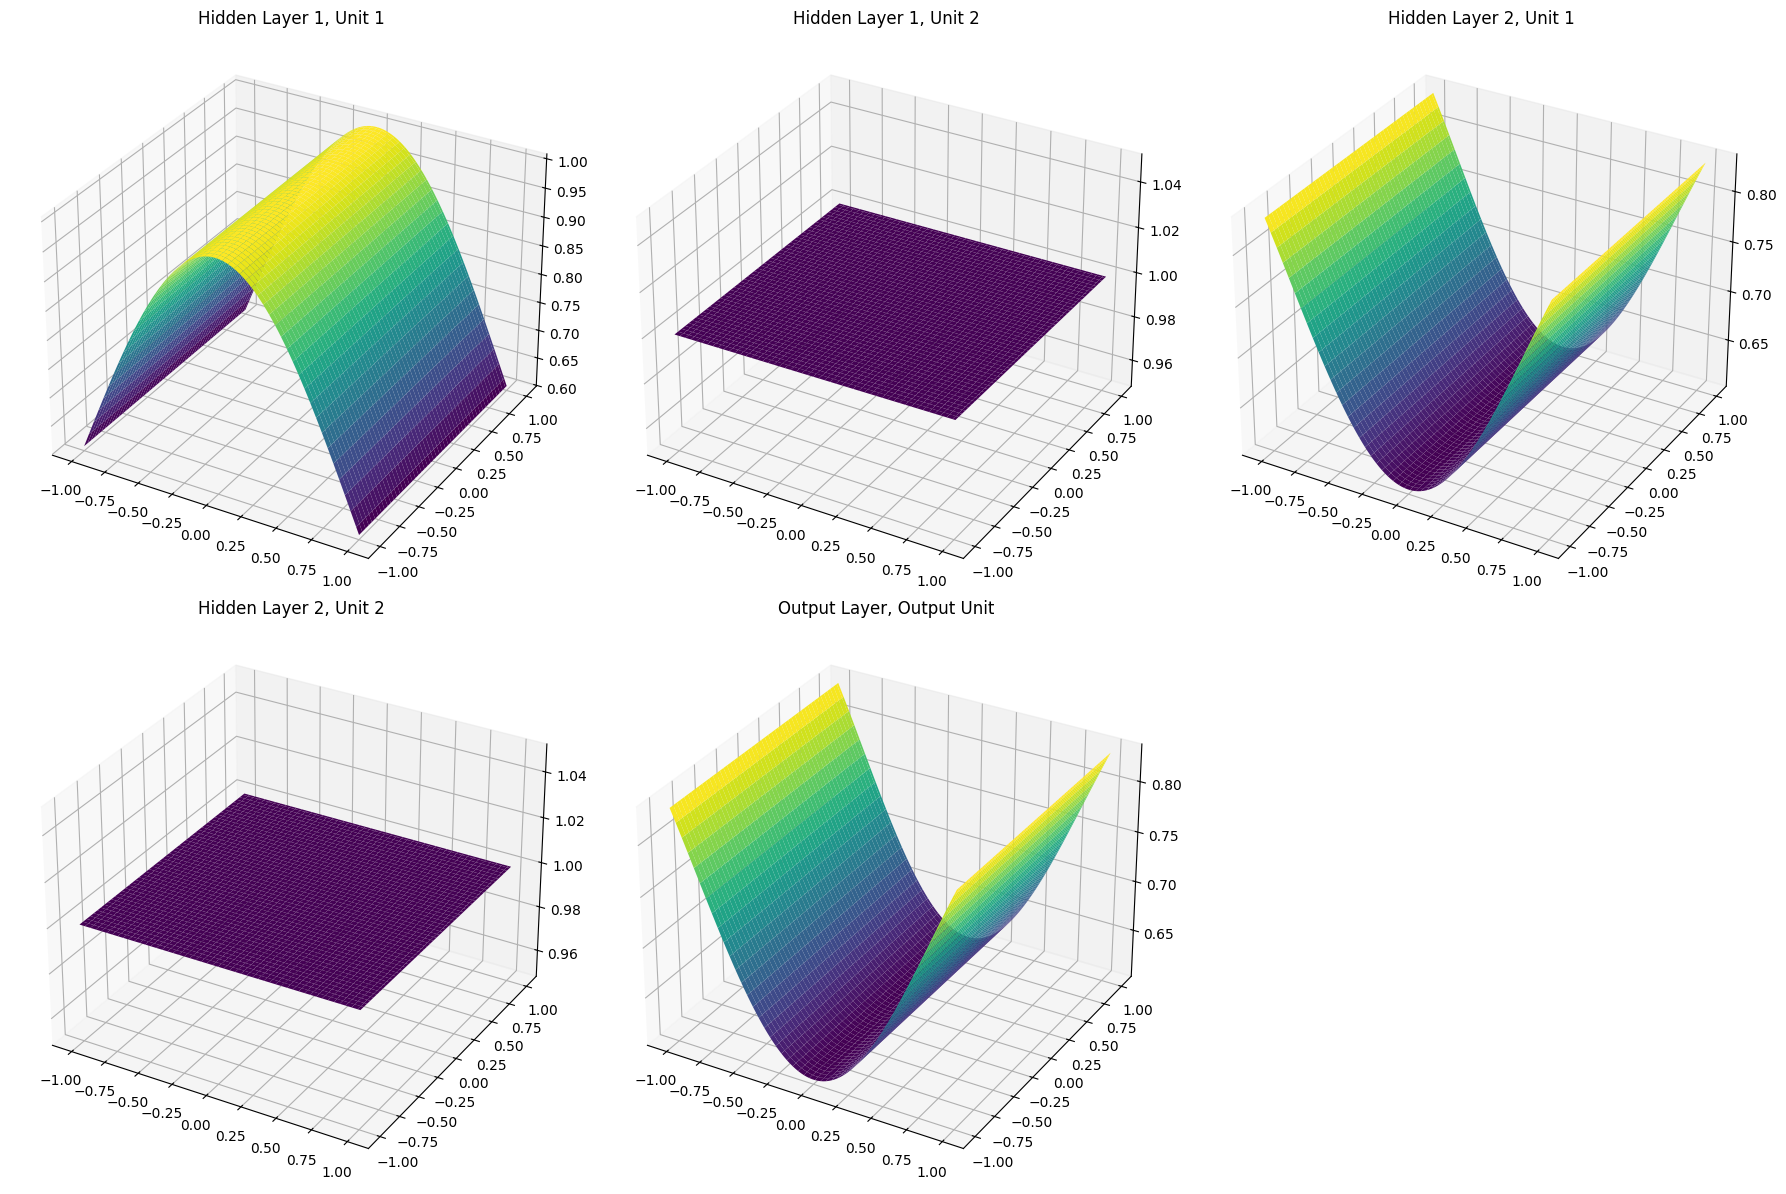

In [31]:
# Example weights and biases
weights1 = np.array([[1, 0], [0, 0]])  # input to first hidden layer
weights2 = np.array([[1, 0], [0, 0]])  # first hidden to second hidden layer
weights3 = np.array([[1, 0]])          # second hidden to output layer

bias1 = np.array([0, 0])  # bias for first hidden layer
bias2 = np.array([0, 0])  # bias for second hidden layer
bias3 = np.array([0])     # bias for output layer

# Call the function to plot activations
plot_activations(weights1, weights2, weights3, bias1, bias2, bias3)




### Second Set of Weights and Biases

The second set of weights and biases used in the model are as follows:

#### Weights

- **Weights from Input to First Hidden Layer (weights1):**
$$
\begin{bmatrix}
10 & 0 \\
0 & 0
\end{bmatrix}
$$

- **Weights from First Hidden Layer to Second Hidden Layer (weights2):**
$$
\begin{bmatrix}
10 & 0 \\
0 & 0
\end{bmatrix}
$$

- **Weights from Second Hidden Layer to Output Layer (weights3):**
$$
\begin{bmatrix}
10 & 0
\end{bmatrix}
$$

#### Biases

- **Bias for First Hidden Layer (bias1):**
$$
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

- **Bias for Second Hidden Layer (bias2):**
$$
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

- **Bias for Output Layer (bias3):**
$$
\begin{bmatrix}
0
\end{bmatrix}
$$


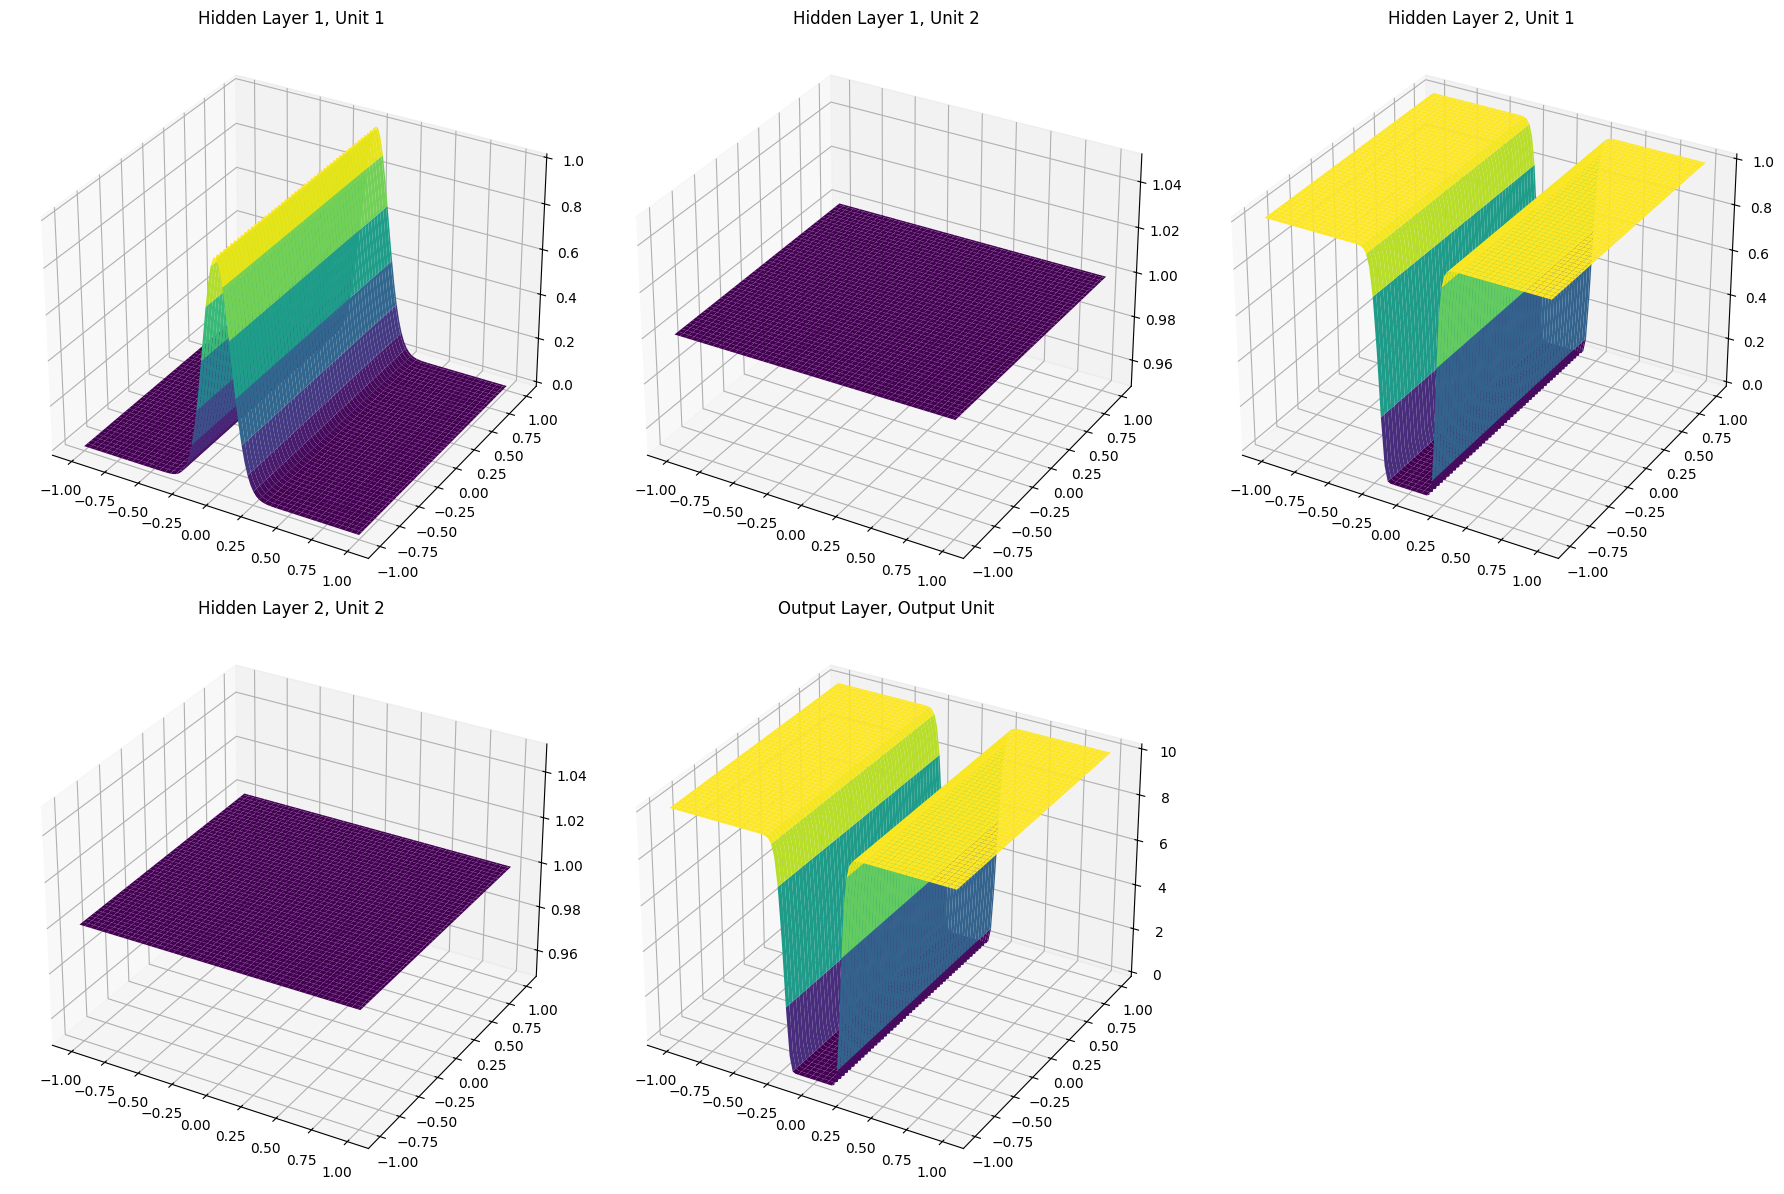

In [32]:
weights1 = np.array([[10,0], [0,0]])  # input to first hidden layer
weights2 = np.array([[10,0], [0,0]])  # first hidden to second hidden layer
weights3 = np.array([10,0])          # second hidden to output layer

bias1 = np.array([0,0])  # bias for first hidden layer
bias2 = np.array([0,0])  # bias for second hidden layer
bias3 = np.array([0])     # bias for


plot_activations(weights1, weights2, weights3, bias1, bias2, bias3)

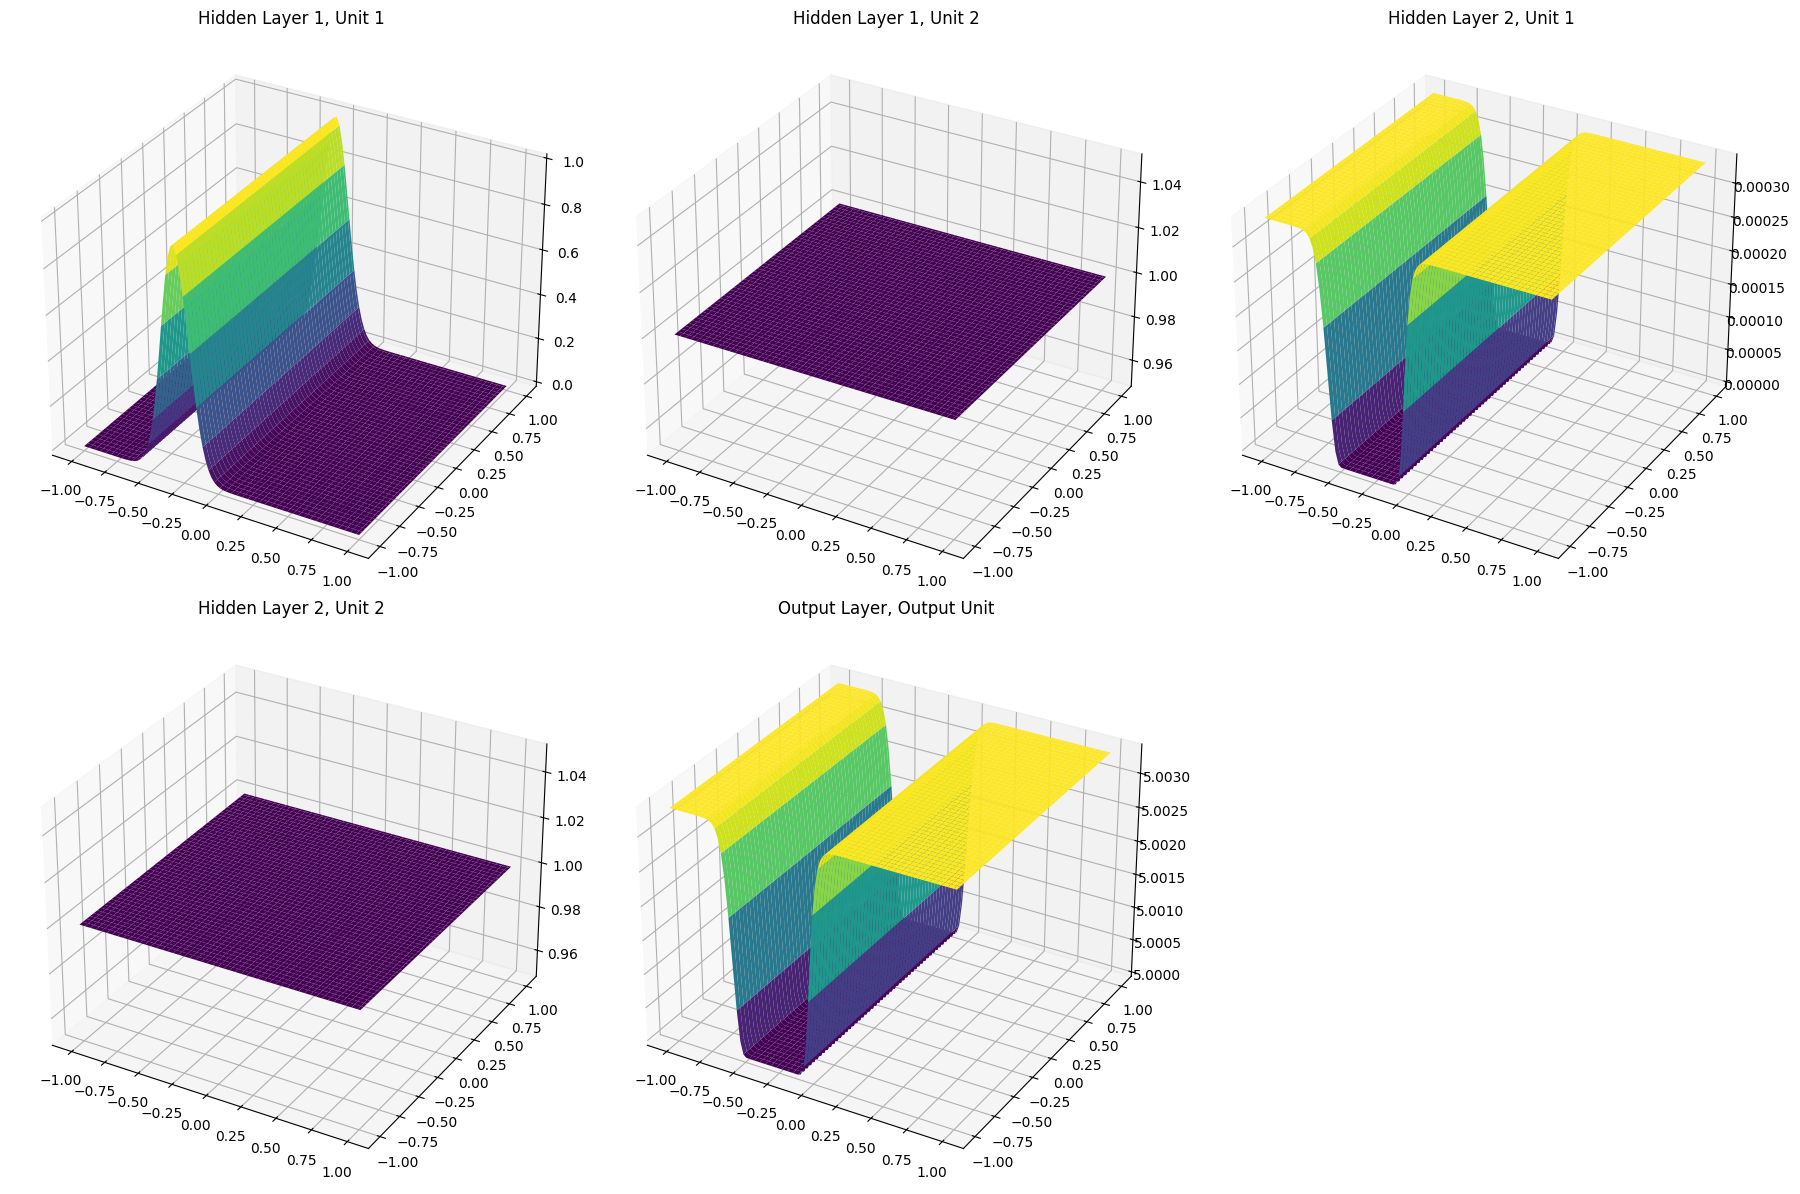

In [34]:
# bias activated
weights1 = np.array([[10,0], [0,0]])  # input to first hidden layer
weights2 = np.array([[10,0], [0,0]])  # first hidden to second hidden layer
weights3 = np.array([10,0])          # second hidden to output layer

bias1 = np.array([3,0])  # bias for first hidden layer
bias2 = np.array([4,0])  # bias for second hidden layer
bias3 = np.array([5])     # bias for output layer

plot_activations(weights1, weights2, weights3, bias1, bias2, bias3)


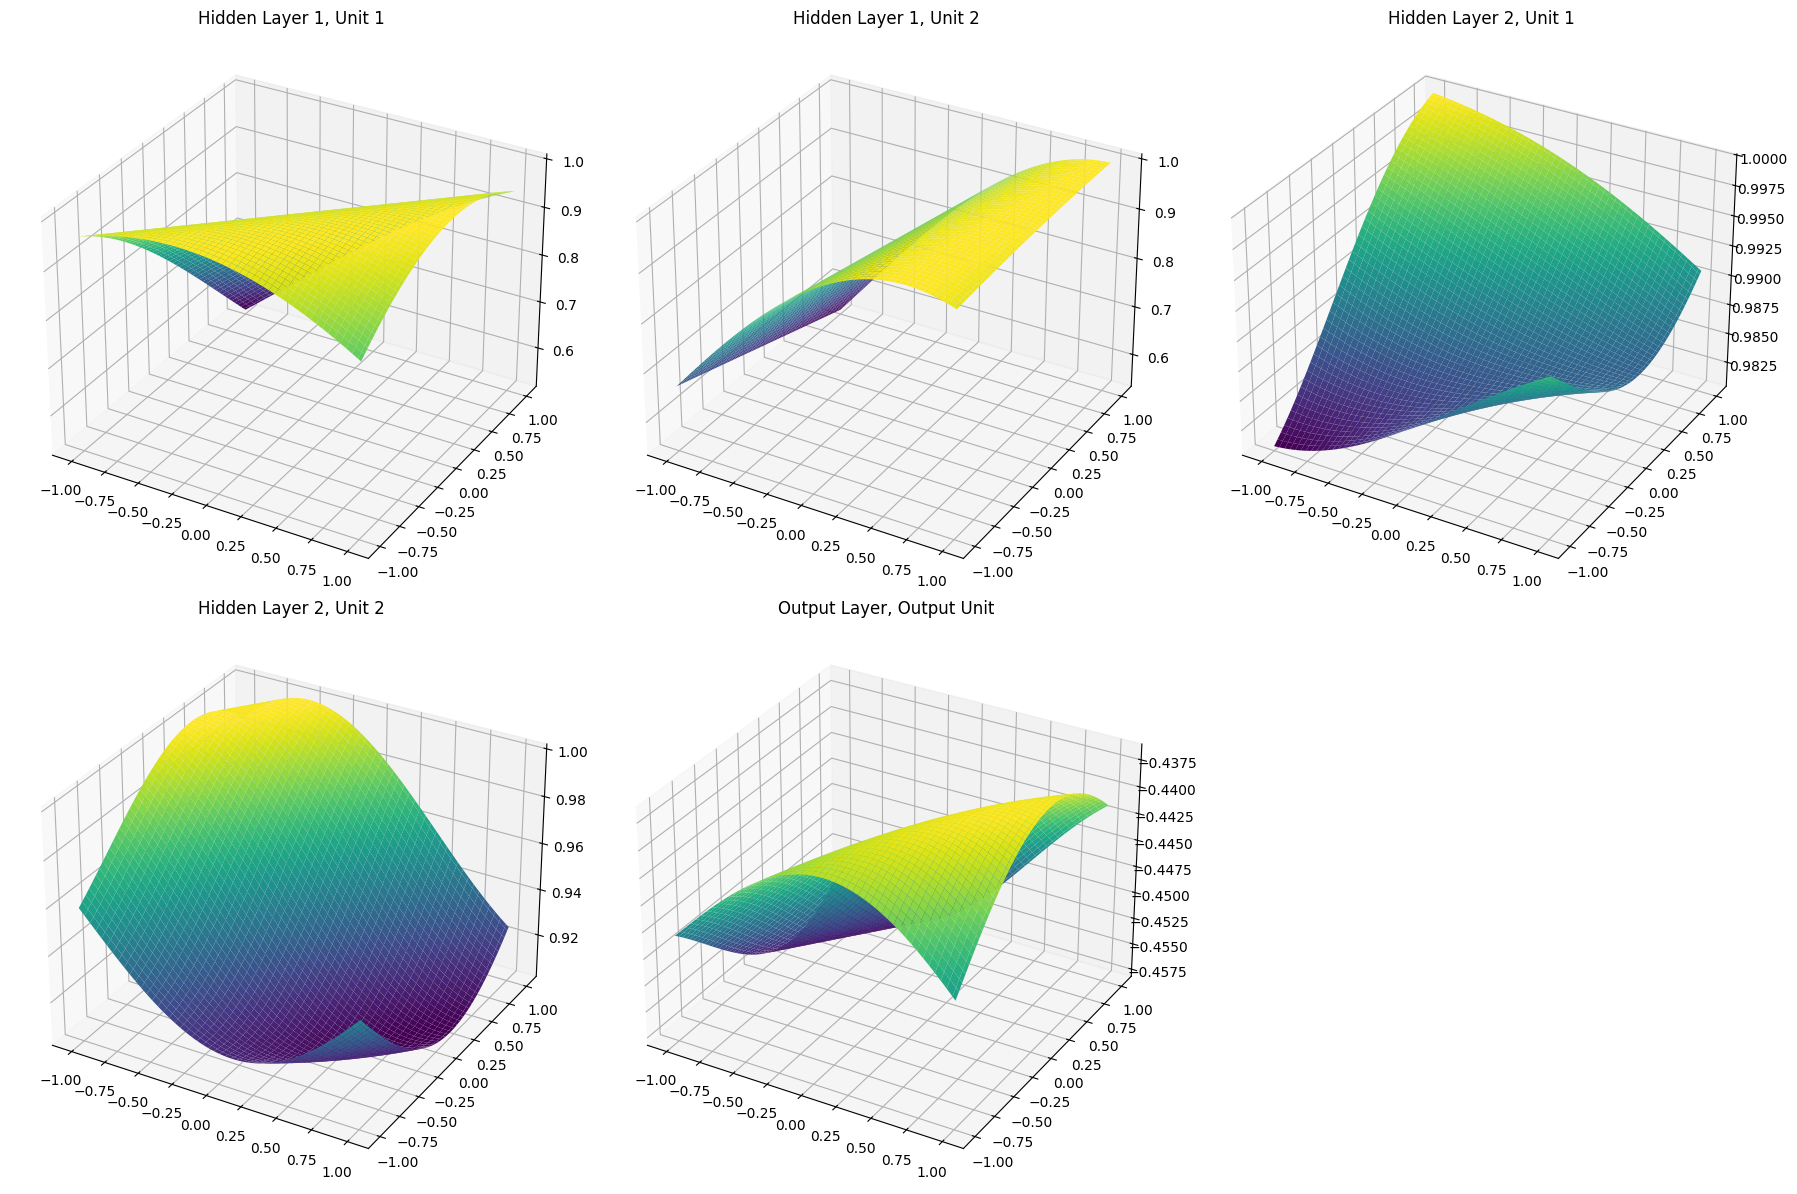

In [35]:
#random weights
np.random.seed(123)

# Randomly initialize weights and biases
weights1 = np.random.uniform(-1, 1, (2, 2))  # 2x2 matrix for input to first hidden layer
weights2 = np.random.uniform(-1, 1, (2, 2))  # 2x2 matrix for first to second hidden layer
weights3 = np.random.uniform(-1, 1, (1, 2))  # 1x2 matrix for second hidden to output layer

bias1 = np.random.uniform(-1, 1, 2)  # Bias for first hidden layer
bias2 = np.random.uniform(-1, 1, 2)  # Bias for second hidden layer
bias3 = np.random.uniform(-1, 1, 1)  # Bias for output layer

# Plot activations with the random weights and biases
plot_activations(weights1, weights2, weights3, bias1, bias2, bias3)